## Parameter optimization for accuracy, speed and memory usage
The used dataset is bursi. The following optimizations are computed on Ubuntu 14.04, CPU: Intel i5-6600@3.3GHz, 16 GB RAM
The results are stored in files and only a visualization is done here. The benchmark is computed with the script runBenchmark.sh.

In [1]:
%matplotlib inline
%load_ext memory_profiler
from neighborsMinHash import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import math
from collections import Counter
import gc

import os.path
import cPickle as pickle

In [2]:
def compute_score(error_list, memory_list, time_list, max_memory, max_time, alpha, beta):
    score_values = []
    for error_, memory_, time_ in zip(error_list, memory_list, time_list):
        error = error_/(float (max_error))
        if memory_ == 0: 
            score_values.append(5)
            continue
        else:
            memory = math.log(memory_/float(max_memory), 10)*alpha
        time = math.log(time_/float(max_time), 10)*beta
        score_values.append(error + memory  + time)
    score_values_np = np.array(score_values)
    min_values_index = np.array(np.where(score_values_np == score_values_np.min()))
    min_values = score_values_np.min()
    return min_values, min_values_index, score_values

In [173]:
def relative_error_reduction(max_error, new_error_list):
    relative_error_reduction_list = []
    for i in new_error_list:
        relative_error_reduction_list.append((max_error - i)/float(max_error))
    return relative_error_reduction

In [22]:
def getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list):
    memory_list = []
    for dist in distribution_pruning:
        memory = 0
        for j in dist[0][0]:
            memory += j * dist[0][0][j]
        memory_list.append(memory)
    tmp_memory = []
    tmp_index = []
    tmp_fitting_time = []
    tmp_query_time = []
    tmp_error_list = []
    for i in xrange(len(memory_list)):
        if memory_list[i] != 0:
            tmp_memory.append(memory_list[i])
            tmp_index.append(iteration_value_list[i])
            tmp_fitting_time.append(time_fit_list[i])
            tmp_error_list.append(error_list[i])
            tmp_query_time.append(time_kneighbors_list[i])
    memory_list = tmp_memory
    iteration_value_list = tmp_index
    time_fit_list = tmp_fitting_time
    error_list = tmp_error_list
    time_kneighbors_list = tmp_query_time
    return memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list

In [53]:
def computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time):
    min_error_value = 1
    best_alpha = 0
    best_beta = 0
    best_score = 0
    best_pruning_value = 0
    plotting_values = []
    epsilon = 0.05 # allow a variance of factor epsilon for the error value
    for alpha_ in np.arange(0.01, 2 ,0.01):
        for beta_ in np.arange(0.01, 2, 0.01):
            result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
    #         print error_list[result[1][0][0]]
            if max_error + epsilon > error_list[result[1][0][0]]:
                if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                    best_score = result[0]
                    best_alpha = alpha_
                    best_beta = beta_
                    min_error_value = error_list[result[1][0][0]]
                    best_pruning_value = result[1][0][0]
                    plotting_values.append([best_score, min_error_value, best_alpha, best_beta])

    print "alpha: ", best_alpha
    print "beta: ", best_beta
    print "Error value: ", min_error_value
    print "Best pruning value: ", best_pruning_value
    print "Score: ", best_score
    return result, plotting_values

In [3]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors,
              mean=None, std=None, fig_size=None):
    if fig_size != None:
        plt.figure(figsize=fig_size)
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    if mean != None:
        par3 = host.twinx()
        par3.plot((mean, min(accuracy)), (mean, min(accuracy)), 'k-')
        par4 = host.twinx()
        par4.plot((std, min(accuracy)), (std, min(accuracy)), 'k-')

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")

    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))

    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    plt.show()

### Distribution of the inverse index

In [4]:
input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/init_values"
if os.path.isfile(input_file_name):
    fileObject = open(input_file_name,'r')
    distribution = pickle.load(fileObject)

#     print distribution[0][0]

In [5]:
# distribution = n_neighbors_minHash.get_distribution_of_inverse_index()
min_ = min(distribution[0][0])
max_ = max(distribution[0][0])

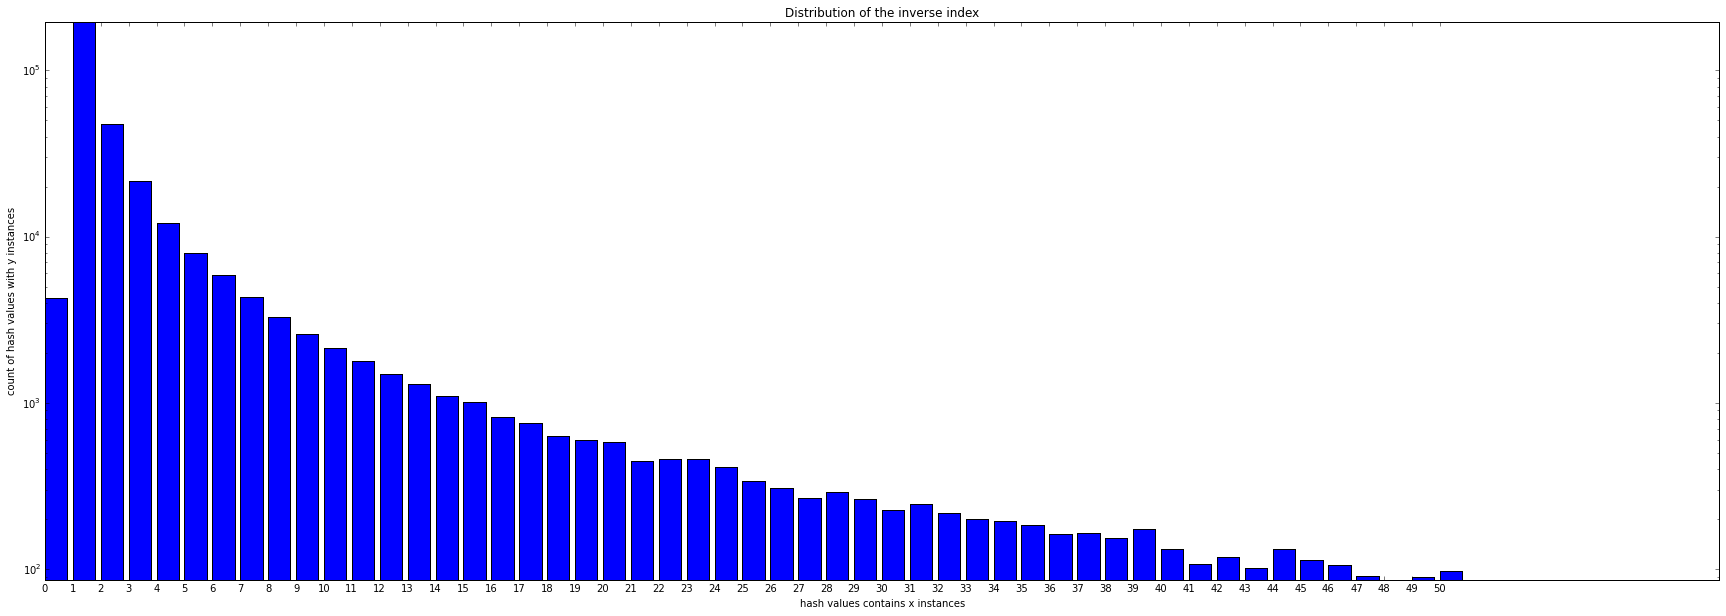

In [6]:
X = np.arange(len(distribution[0][0]))
plt.figure(figsize=(30, 10))
plt.yscale('log')
plt.bar(X, distribution[0][0].values())
plt.xticks(X, distribution[0][0].keys())
ymax = max(distribution[0][0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.show()

### Compute the maximum values for time, memory usage and the error value

In [7]:
max_error = 1 - distribution[3]
max_time = distribution[2]
memory_list = []
max_memory = 0
for i in distribution[0][0]:
    memory_list.append(distribution[0][0][i])
    max_memory += distribution[0][0][i]


### Best pruning value for the frequency of occurences of hash values

In [28]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
for i in xrange(1, 52):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/prune_index_frequencey+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [29]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index after pruning hash values with an occurence less than n

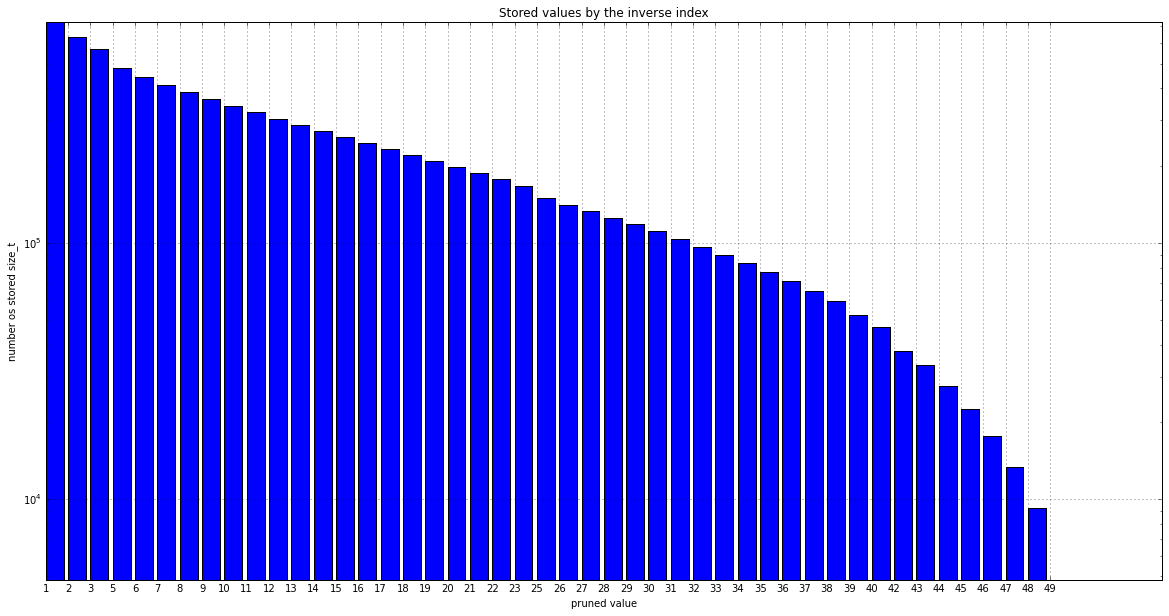

In [30]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

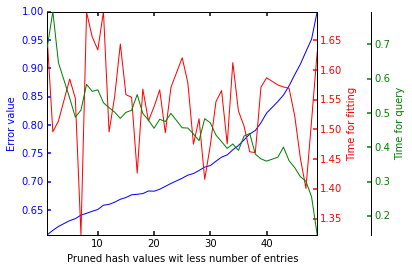

In [31]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list,
           "Pruned hash values wit less number of entries", "Error value",
           "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [122]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  1.99
beta:  1.99
Error value:  0.640903850588
Best pruning value:  4
Score:  1.15543708827


#### Optimization for memory usage and speed

Best value for pruning:  7  with value:  1.67918216834


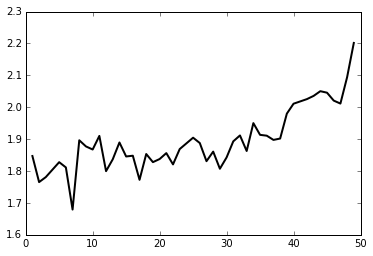

In [34]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=1.99)
# print result
plt.plot(iteration_value_list, result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

### Removing hash functions with less hash values than n

In [183]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
iteration_value = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
#  = [85 328 434 496 522 579 608 641 658 679 705 716 733 757 765 778 793 808 817 829 840 853 868 882 891 900 912 920 927 940 953 962 973 989 998 1023 1045 1065 1092 1126]
for i in iteration_value:
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_function_pruned+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

# print len(distribution_pruning)
# print distribution_pruning

In [184]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

In [185]:
print len(memory_list)

37


#### Stored elements in the inverse index after pruning

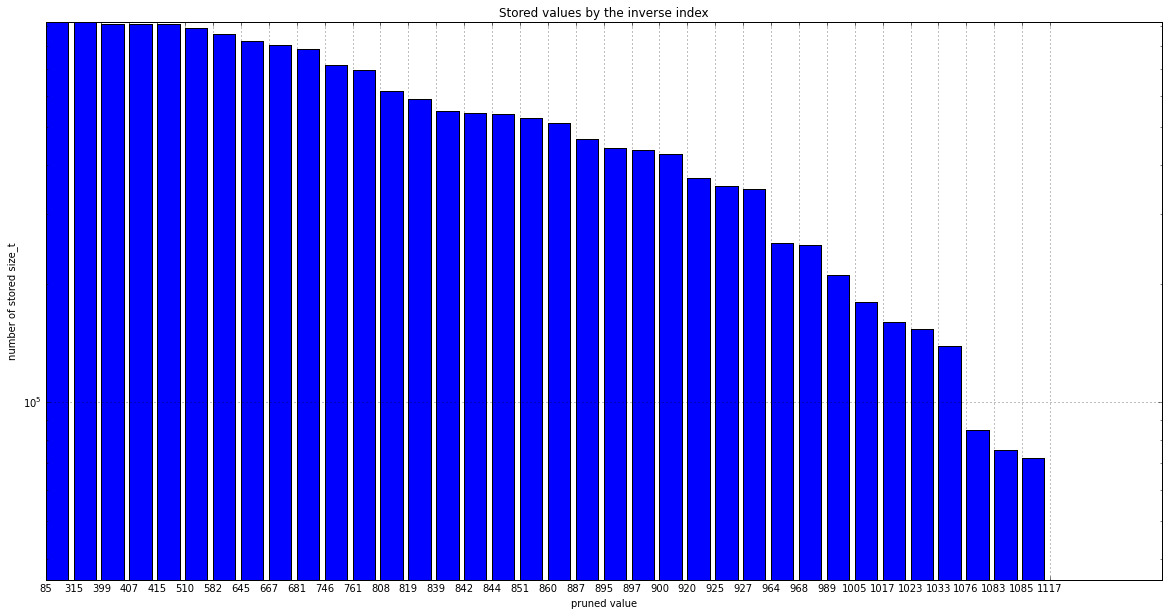

In [103]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

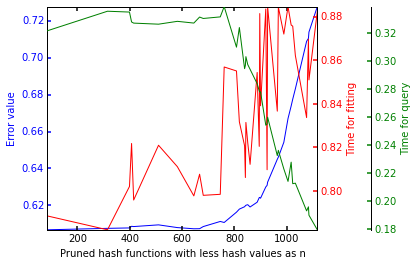

In [104]:
createPlot(iteration_value, error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [121]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  1.99
beta:  1.99
Error value:  0.640903850588
Best pruning value:  4
Score:  1.15543708827


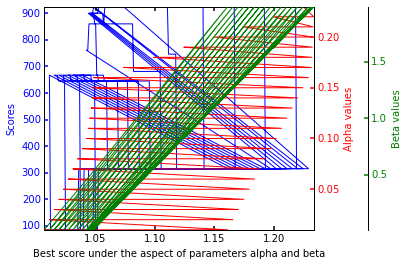

In [42]:

createPlot(score_list, pruning_value_list,  alpha_list, beta_list, 
           "Best score under the aspect of parameters alpha and beta",
           "Scores", "Alpha values", "Beta values")

#### Optimization for memory usage and speed

Best value for pruning:  925  with value:  1.23379599661


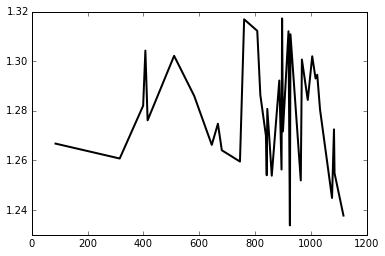

In [106]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.23, beta=1.99)
# print result
plt.plot(iteration_value, result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value[result[1][0][0]], " with value: ", result[0]

### Influence of shingels

#### Concaternate values of a shingleton

In [116]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
for i in xrange(1, 6):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/shingle_concat+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)

In [117]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

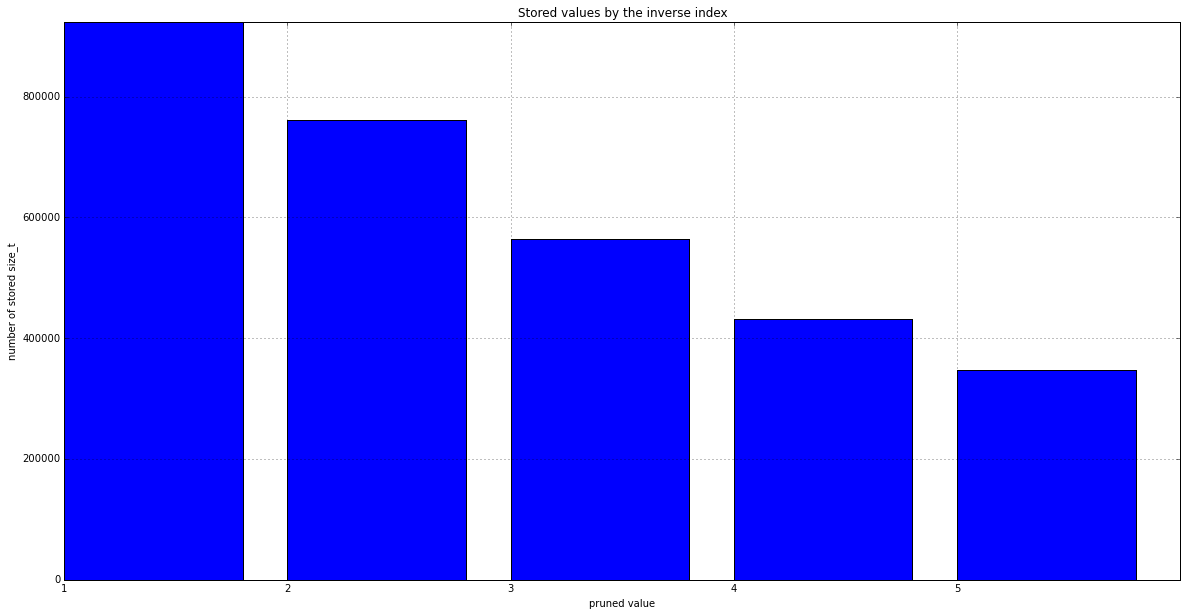

In [118]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

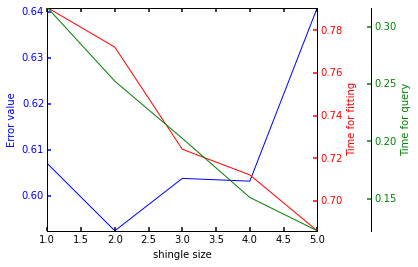

In [126]:
createPlot(range(1, len(iteration_value_list)+1), error_list, time_fit_list, time_kneighbors_list, 
           "shingle size",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [127]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  1.99
beta:  1.99
Error value:  0.640903850588
Best pruning value:  4
Score:  1.15543708827


#### Optimization for memory usage and speed

Best value for pruning:  5  with value:  1.15543708827


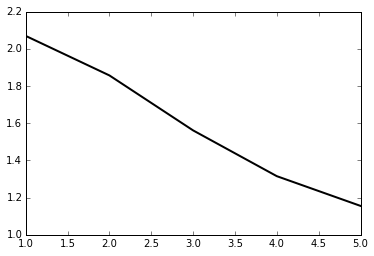

In [128]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=1.99, beta=1.99)
# print result
plt.plot(range(1,6), result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

#### Take minimum value of shingelton

In [130]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1

for i in xrange(1, 6):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/shingle_min_val+" + str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])

# print len(distribution_pruning)
# print distribution_pruning
# print error_list

In [131]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

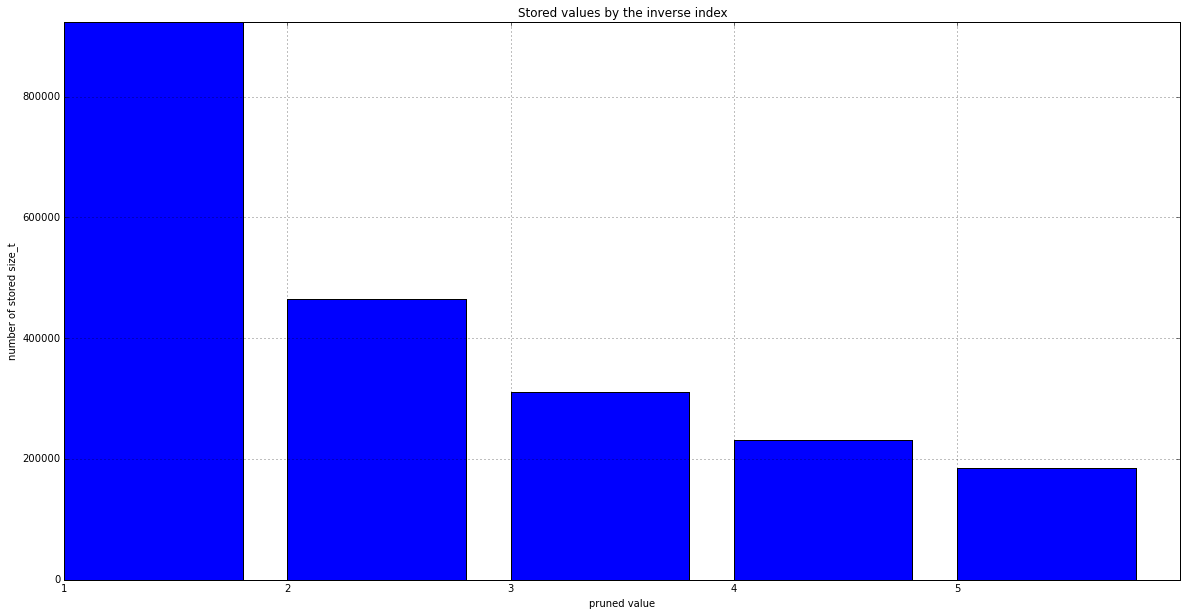

In [132]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

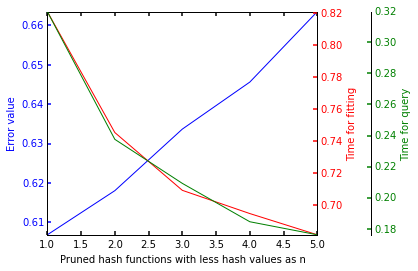

In [133]:
createPlot(iteration_value_list, error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [134]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  0.3
beta:  0.06
Error value:  0.645607562831
Best pruning value:  3
Score:  1.02274329467


#### Optimization for memory usage and speed

Best value for pruning:  3  with value:  1.02274329467


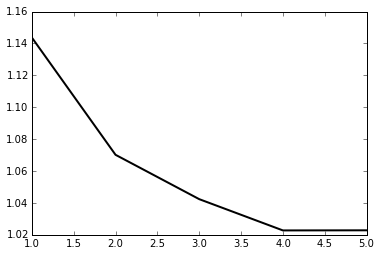

In [135]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.3, beta=0.06)
# print result
plt.plot(range(1,6), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]

### Frequencey of pruning

#### Removing hash functions with less hash values than n

In [136]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
for i in frequency_pruning:
    for j in xrange(1, 10):
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/freqency_pruning_and_occurences+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])
            iteration_value_list.append([i,j])


In [137]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

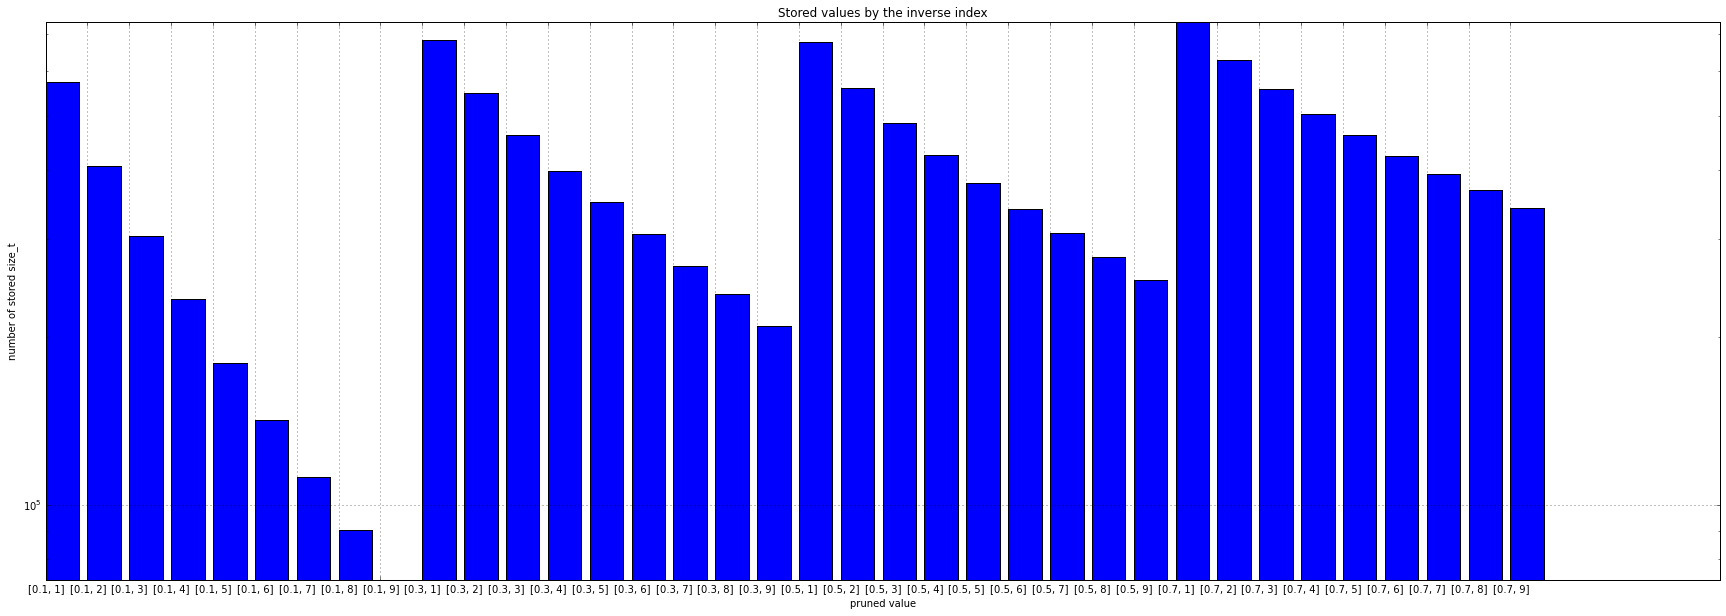

In [138]:
data = np.arange(len(memory_list))
plt.figure(figsize=(30, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

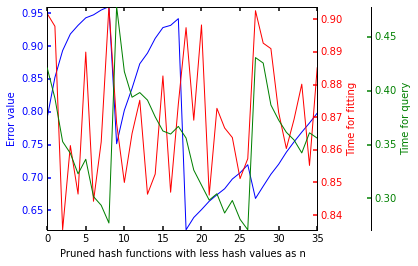

In [139]:
createPlot(range(len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [140]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  0.34
beta:  0.06
Error value:  0.620659442011
Best pruning value:  18
Score:  1.14149201205


#### Optimization for memory usage and speed

Best value for pruning:  [0.5, 1]  with value:  1.14149201205


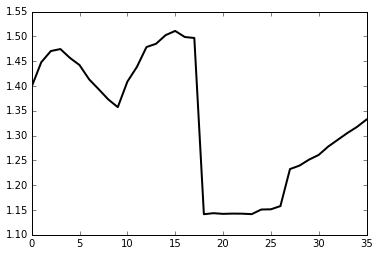

In [141]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.34, beta=0.06)
# print result
plt.plot(range(len(iteration_value_list)), result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

#### Best pruning value for the frequency of occurences of hash values

In [142]:
# max(distribution_inverse_index_max[0][0].iterkeys())+1)
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.1, 0.3, 0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in frequency_pruning:
    for j in iteration_value:
        
        input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/frequencey_pruning_and_size_hash_values+"+str(i)+ "+" +str(j)
        if os.path.isfile(input_file_name):
            fileObject = open(input_file_name,'r')
            dist_tmp = pickle.load(fileObject)
            distribution_pruning.append(dist_tmp)
            error_list.append(1 - dist_tmp[3])
            time_fit_list.append(dist_tmp[1])
            time_kneighbors_list.append(dist_tmp[2])
            iteration_value_list.append([i,j])

# print len(distribution_pruning)
# print distribution_pruning
# print error_list

In [143]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

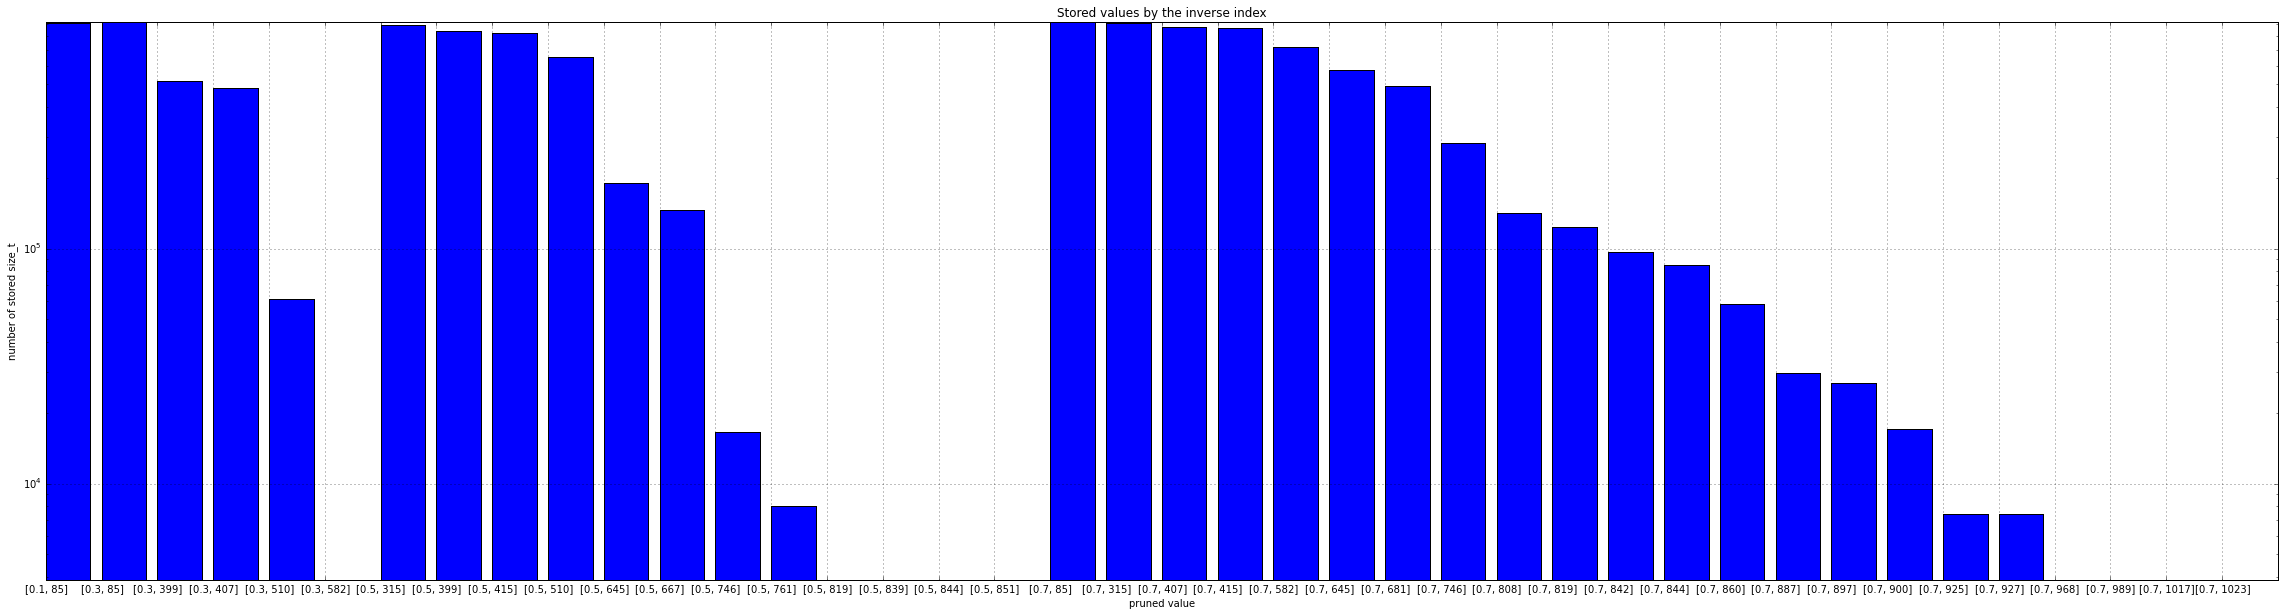

In [144]:
data = np.arange(len(memory_list[0::3]))
plt.figure(figsize=(40, 10))
plt.width=1
plt.yscale('log')
plt.bar(data, memory_list[0::3])
plt.xticks(data, iteration_value_list[0::3])
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

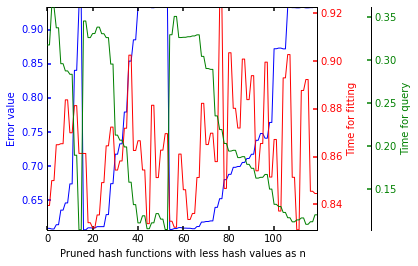

In [145]:
createPlot(range(0, len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [146]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  0.16
beta:  1.99
Error value:  0.60903850588
Best pruning value:  20
Score:  1.27712865239


#### Optimization for memory usage and speed

Best value for pruning:  [0.5, 399]  with value:  1.27712865239


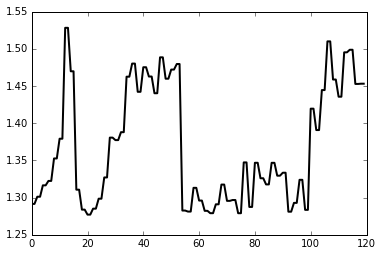

In [147]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.16, beta=1.99)
# print result
plt.plot(range(len(iteration_value_list)), result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

### Remove least significant n-bits

In [176]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
iteration_value_list = []
index_shift = 1
for i in xrange(1, 11):
    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/remove_least_significant_bit+"+str(i)
    if os.path.isfile(input_file_name):
        fileObject = open(input_file_name,'r')
        dist_tmp = pickle.load(fileObject)
        distribution_pruning.append(dist_tmp)
        error_list.append(1 - dist_tmp[3])
        time_fit_list.append(dist_tmp[1])
        time_kneighbors_list.append(dist_tmp[2])
        iteration_value_list.append(i)


In [177]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

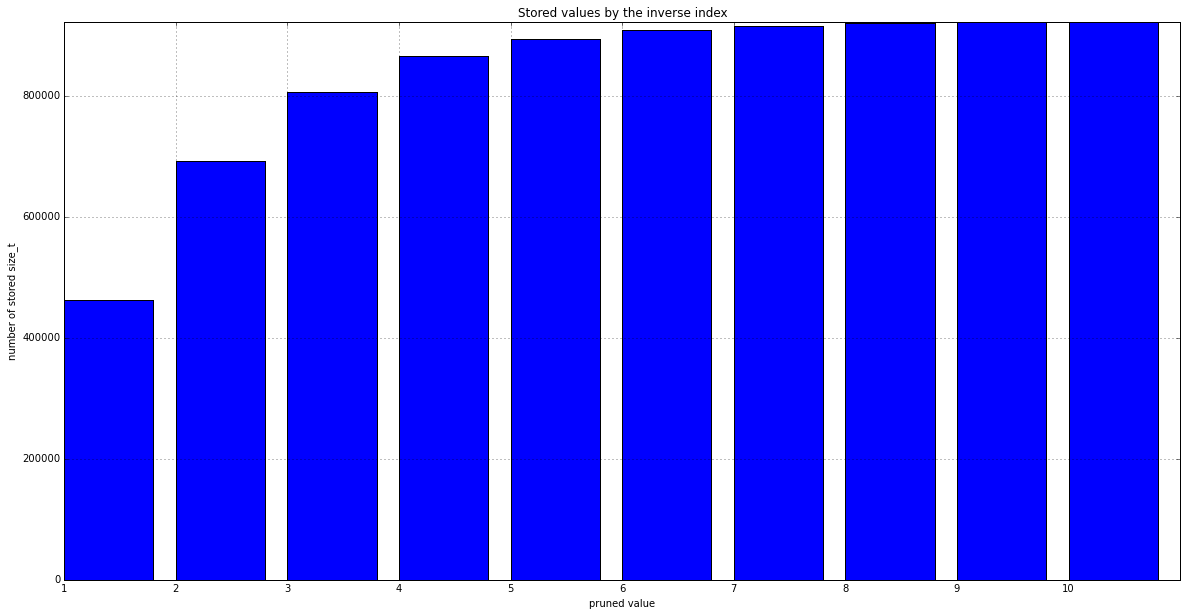

In [178]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.width=1
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

In [ ]:
createPlot(range(0, len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [179]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  1.99
beta:  1.99
Error value:  0.620290523403
Best pruning value:  0
Score:  1.41704271019


#### Optimization for memory usage and speed

Best value for pruning:  1  with value:  1.41704271019


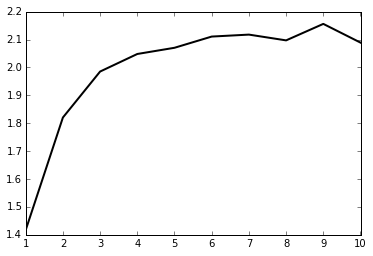

In [181]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=1.99, beta=1.99)
# print result
plt.plot(range(1, len(iteration_value_list)+1), result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]

### All methods together

In [187]:
error_list = []
time_fit_list = []
time_kneighbors_list = []
distribution_pruning = []
# prune_index_frequencey+${i}
index_shift = 1
index_values = []
frequency_pruning = [0.5, 0.7, 1]
iteration_value_list = []
file_obj = open("/home/joachim/thesis/minHashNearestNeighbors/result/size_of_hash_functions", 'r')
lines = file_obj.readlines()
for i in lines:
    iter_str = i.strip().split(" ")
    for i in iter_str:
        iteration_value.append(int(i))
file_obj.close()
iteration_value = sorted(iteration_value)
for i in [0, 1]:
    for j in [-1, 0.5]:
        for k in [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for l in iteration_value:
                for m in [4, 5]:
                    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/all+"+str(i)+ "+" +str(j)+ "+" +str(k)+ "+" +str(l)+"+" +str(m)
                    if os.path.isfile(input_file_name):
                        fileObject = open(input_file_name,'r')
                        dist_tmp = pickle.load(fileObject)
                        distribution_pruning.append(dist_tmp)
                        error_list.append(1 - dist_tmp[3])
                        time_fit_list.append(dist_tmp[1])
                        time_kneighbors_list.append(dist_tmp[2])
                        iteration_value_list.append([i,j,k,l,m])
                for m in [1, 2, 3]:
                    input_file_name = "/home/joachim/thesis/minHashNearestNeighbors/result/all+"+str(i)+ "+" +str(j)+ "+" +str(k)+ "+" +str(l)+"+" +str(m)
                    if os.path.isfile(input_file_name):
                        fileObject = open(input_file_name,'r')
                        dist_tmp = pickle.load(fileObject)
                        distribution_pruning.append(dist_tmp)
                        error_list.append(1 - dist_tmp[3])
                        time_fit_list.append(dist_tmp[1])
                        time_kneighbors_list.append(dist_tmp[2])
                        iteration_value_list.append([i,j,k,l,m])
                        
                
# print error_list

In [188]:
memory_list, iteration_value_list, time_fit_list, error_list, time_kneighbors_list = \
getMemory(distribution_pruning, iteration_value_list, time_fit_list, error_list, time_kneighbors_list)

#### Stored elements in the inverse index

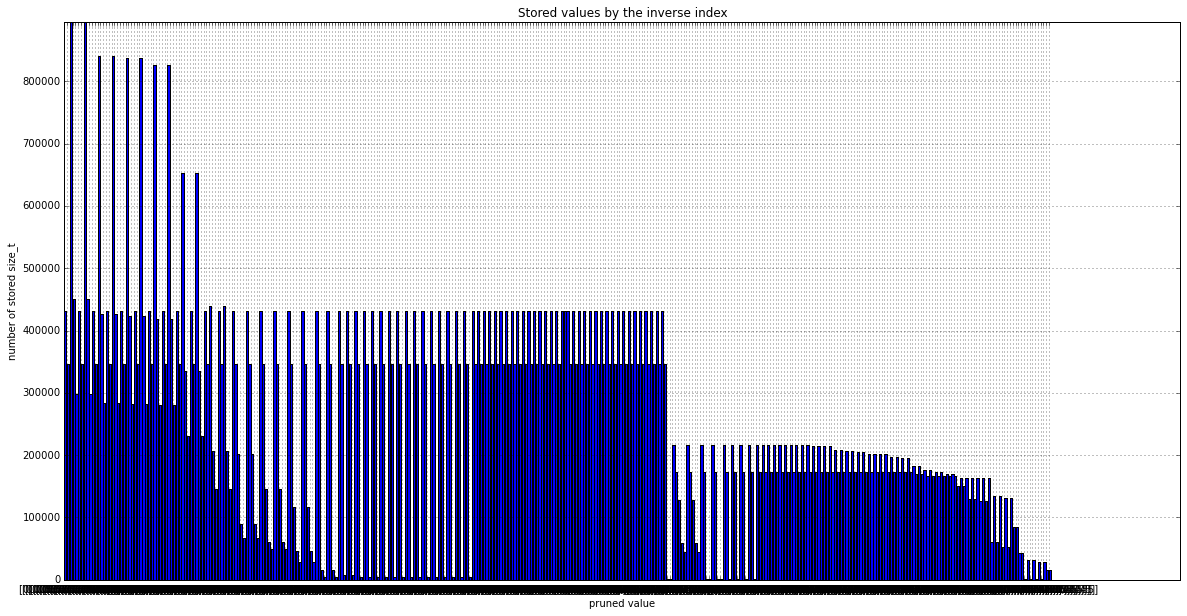

In [189]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.width=1
# plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, iteration_value_list)
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.grid()
plt.ylabel("number of stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time

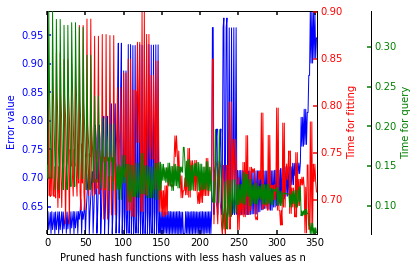

In [190]:
createPlot(range(0, len(iteration_value_list)), error_list, time_fit_list, time_kneighbors_list, 
           "Pruned hash functions with less hash values as n",
           "Error value", "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [191]:
result, plotValues = computeAlphaBeta(error_list, memory_list, time_fit_list, max_memory, max_time)

alpha:  0.27
beta:  1.99
Error value:  0.636292367996
Best pruning value:  236
Score:  1.02131526164


#### Optimization for memory usage and speed

Best value for pruning:  [1, 0.5, -1, 407, 4]  with value:  1.02131526164


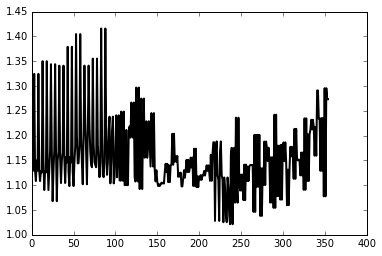

In [195]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.27, beta=1.99)
# print result
plt.plot(range(1, len(iteration_value_list)+1), result[2], 'k-', lw=2)
print "Best value for pruning: ", iteration_value_list[result[1][0][0]], " with value: ", result[0]